In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import beta
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
from tqdm.notebook import tqdm

sns.set_theme("paper", "white")

In [2]:
df_users = pd.read_csv("./DSock/Active_Users.csv", index_col=0)
print(df_users.shape)
display(df_users.head())

(116, 55)


,MTurk_ID,username,id,isMod,isObserver,isPuppet,n_reports,puppet,report,issued_posts,...,Q17,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Strategy
1,A10IUXCZBNYUXC,Jacob_1907,2658,f,f,f,17,0,1,25,...,2.0,2.0,2.0,1.0,1.0,2.0,1.0,4.0,2.0,NaN
2,A15F2JTVAJXITI,Luke_3376,2297,f,t,f,0,0,0,0,...,1.0,3.0,1.0,3.0,1.0,3.0,1.0,4.0,1.0,NaN
3,A173A97OFDAX9F,Claire_679,2601,f,f,f,0,0,0,4,...,1.0,2.0,2.0,1.0,1.0,2.0,1.0,3.0,3.0,NaN
4,A18XVBWB2A270I,Katherine_2323,2338,f,t,f,0,0,0,0,...,1.0,2.0,4.0,2.0,2.0,2.0,1.0,1.0,3.0,NaN
5,A1AIMKA54UBYIQ,Asia_4906,2638,f,f,f,1,0,1,9,...,3.0,3.0,2.0,1.0,2.0,2.0,2.0,4.0,3.0,NaN


In [3]:
df_evals = pd.read_csv("./DSock/human_eval_analysis/attitude_tracking.csv")

df_evals = pd.merge(df_users, df_evals, how="left", left_on="MTurk_ID", right_on="id").rename({"id_x": "id"}, axis=1)

df_evals.index = [f"u{u}" for u in df_evals["id"]]

In [4]:
topics = list("abcdefgh")
topics_num = list(range(9))
deltas = ["10", "21", "32", "43", "54"]

In [5]:
timeline = pd.date_range("2020-09-03-03:59:59", periods=6, tz="utc")

get_change = lambda u, t: df_evals.loc[u][[f"{t}_delta_{d}" for d in deltas]].tolist()

In [6]:
u_change = {
    u: {t: (np.array(get_change(u, t)) != 0).sum() for t in topics}
    for u in df_evals.index
}

## get events

+ post events -> nodes
+ comment events -> nodes
+ view events -> nodes
+ like events -> nodes
+ influence -> edges

In [7]:
df_posts = pd.read_csv("./DSock/direct_influence/posts_with_senti_and_topic.csv", parse_dates=["createdAt"])
df_comts = pd.read_csv("./DSock/direct_influence/comments_with_senti_and_topic.csv", delimiter=",", parse_dates=["createdAt"]).dropna(subset=["CommenterId", "PostId"])
df_views = pd.read_csv("./DSock/postViews.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_likes = pd.read_csv("./DSock/Likes.csv", delimiter="|", parse_dates=["createdAt"]).dropna(subset=["UserId", "PostId"])
df_repts = pd.read_csv("./DSock/ReportUsers.csv", delimiter="|", parse_dates=["createdAt"])

print(f"posts: {df_posts.shape}, comments: {df_comts.shape}, views: {df_views.shape}, likes: {df_likes.shape}, reports: {df_repts.shape}")

posts: (1057, 11), comments: (1615, 11), views: (234178, 10), likes: (1034, 6), reports: (46, 6)


In [8]:
df_likes["UserId"] = df_likes["UserId"].astype(int)
df_likes["PostId"] = df_likes["PostId"].astype(int)

df_comts["CommenterId"] = df_comts["CommenterId"].astype(int)
df_comts["PostId"] = df_comts["PostId"].astype(int)

In [9]:
df_annot_posts = pd.read_csv("./DSock/posts_anno_labels.csv")
df_posts = df_posts.merge(df_annot_posts[["post_id", "majority_topic_label", "majority_sent_label"]], left_on="PostID", right_on="post_id")

In [10]:
df_annot_comts = pd.read_csv("./DSock/comments_anno_labels.csv")
df_comts = df_comts.merge(df_annot_comts[["comment_id", "majority_topic_label", "majority_sent_label"]], left_on="id", right_on="comment_id")

### create influence graph

In [11]:
G = nx.DiGraph()
for u, uname, obsr, sock in df_users[["id", "username", "isObserver", "isPuppet"]].values:
    G.add_node(f"u{u}", id=u, kind="user", name=uname, observer=(obsr == "t"), sock=(sock == "t"))
    if obsr == "t":
        G.nodes[f"u{u}"]["color"] = "obsr"
    elif sock == "t":
        G.nodes[f"u{u}"]["color"] = "sock"
    else:
        G.nodes[f"u{u}"]["color"] = "part"

for p, u, t, polar, score, topic in df_posts[["PostID", "AuthorId", "createdAt", "majority_sent_label", "scores", "majority_topic_label"]].values:
    if f"u{u}" in G.nodes:
        G.add_node(f"p{p}", id=p, kind="post", time=t, user=u, polar=polar, score=score, topic=topic)

for c, u, p, t, polar, score, topic in df_comts[["id", "CommenterId", "PostId", "createdAt", "majority_sent_label", "scores", "majority_topic_label"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"c{c}", id=c, kind="comt", time=t, user=u, polar=polar, score=score, topic=topic)
        G.add_edge(f"c{c}", f"p{p}", kind="known", time=t, weight=1)
        G.add_edge(f"p{p}", f"c{c}", kind="known", time=t, weight=1)

for l, u, p, t in df_likes[["id", "UserId", "PostId", "createdAt"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"l{l}", user=f"u{u}", post=f"p{p}", time=t, id=l, kind="like",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"u{u}", f"l{l}", time=t, weight=1, kind="infer")
        G.add_edge(f"l{l}", f"p{p}", time=t, weight=1, kind="known")

for u, p, t, v in df_views[["UserId", "PostId", "createdAt", "id"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        G.add_node(f"v{v}", user=f"u{u}", post=f"p{p}", time=t, id=v, kind="view",
                   topic=G.nodes[f"p{p}"]["topic"], polar=G.nodes[f"p{p}"]["polar"], score=1)
        G.add_edge(f"u{u}", f"v{v}", time=t, weight=1, kind="infer")
        G.add_edge(f"v{v}", f"p{p}", time=t, weight=1, kind="known")

In [12]:
user_view = {u: set() for u in G if u[0] == "u"}
for u, p, t, v in df_views[["UserId", "PostId", "createdAt", "id"]].values:
    if f"u{u}" in G.nodes and f"p{p}" in G.nodes:
        user_view[f"u{u}"].add(f"v{v}")

In [13]:
for p in tqdm(G):
    if p[0] == "p":
        u = f"u{G.nodes[p]['user']}"
        for v in user_view[u]:
            if G.nodes[v]["time"] <= G.nodes[p]["time"]:
                G.add_edge(p, v, time=G.nodes[v]["time"], weight=1, kind="infer")

## On average, one user will read the same post almost 10 times!

In [14]:
up = [(G.nodes[n]["user"], G.nodes[n]["post"]) for n in G.nodes if n[0] == "v"]

print(f"{len(up)} {len(set(up))} {len(up)/len(set(up))}")

214351 21442 9.996782016602928


In [15]:
print(f"{len(G)} {len(G.edges)}")

218011 1728271


#### define colors and styles for graph drawing

In [16]:
use_color = sns.color_palette("tab10")
use_color

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [17]:
line_map = {
    "view": "-",
    "like": ".",
}

color_map = {
    "view": 4,
    "like": 1,
    
    "known": 4,
    "infer": 4,
    
    "part": 2,
    "sock": 3,
    "obsr": 7,
    
    "make": 5,
    "comt": 9,
    "post": 0,
    
    "user": 8,
}

style_map = {
    "post": "o",
    "comt": "s",
}

In [49]:
def describe_graph(graph):
    return {
        "nodes": len(graph.nodes),
        "edges": len(graph.edges),
        "components": nx.number_weakly_connected_components(graph),
        "density": nx.density(graph),
        "diameter": nx.diameter(graph.to_undirected()) if nx.is_connected(graph.to_undirected()) else None,
        "degree": len(graph.edges)/len(graph.nodes),
    }

def draw_graph(subG, prog=None, edge_label=False, node_label=False, node_size=None, figsize=(10, 10), pr_value=None):
    if prog in ["dot", "neato"]:
        pos = nx.drawing.nx_agraph.graphviz_layout(subG, prog=prog)
    else:
        pos = nx.spring_layout(subG, seed=5, iterations=10)

    fig = plt.figure(figsize=figsize)
    ax = fig.subplots()

    nx.draw(
        subG, ax=ax,
        pos=pos,
        with_labels=node_label,
        node_color=[use_color[color_map[subG.nodes[n]["kind"]]]
                    if n[0] != "u" else use_color[color_map[subG.nodes[n]["color"]]]
                    for n in subG.nodes],
        edge_color=[use_color[color_map[subG.edges[e]["kind"]]] for e in subG.edges],
        labels={n: f"{n}\n{subG.nodes[n]['polar']}" if subG.nodes[n]['kind'] != "user" else n for n in subG.nodes},
        font_size=10,
        node_size=[pr_value[n]*len(subG)*100 for n in subG] if pr_value else 300,
    )

    nx.draw_networkx_edge_labels(
        subG, pos=pos, ax=ax,
        edge_labels={e: f"{subG.edges[e]['time']:%d-%H:%M}" for e in subG.edges} if edge_label else {e: "" for e in subG.edges}
    )
    print(describe_graph(subG))

{'nodes': 11, 'edges': 10, 'components': 1, 'density': 0.09090909090909091}


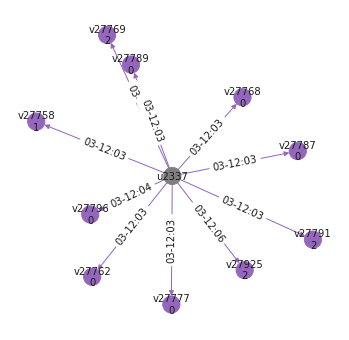

In [19]:
node_name = "u2337"
topic = 7

node_list = [e[1] for e in G.out_edges(node_name) if G.nodes[e[1]]["topic"] == topic][:10] + [node_name]
subG = nx.subgraph(G, node_list)
draw_graph(subG, edge_label=True, node_label=True, figsize=(6, 6))

## full influence graph

3492
118


/home/rui/venvs/gcn/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: obsr is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


{'nodes': 118, 'edges': 222, 'components': 1, 'density': 0.016079965232507605}


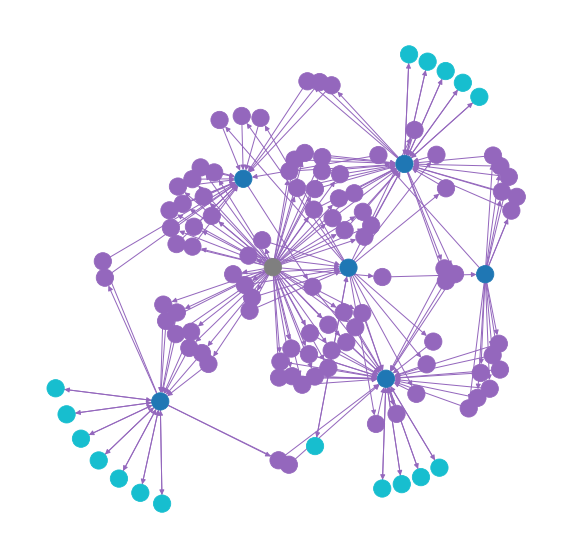

In [20]:
node_name = "u2337"
topic = 4
polarity = 0

descendants_full = [n for n in nx.descendants(G, node_name)
                if G.nodes[n]["topic"] == topic and G.nodes[n]["polar"] == polarity]

np.random.seed(4)
# descend_full = np.random.choice(descend_full, 65, replace=False).tolist()

subG = G.subgraph(descendants_full + [node_name]).copy()
print(len(subG))

subG = subG.subgraph([n for n in subG if nx.has_path(subG, node_name, n)])
print(len(subG))

draw_graph(subG, prog="neato", edge_label=False, node_label=False, pr_value=None)

nodes 118, edges: 222
nodes 24, edges: 34
{'nodes': 24, 'edges': 34, 'components': 7, 'density': 0.06159420289855073}


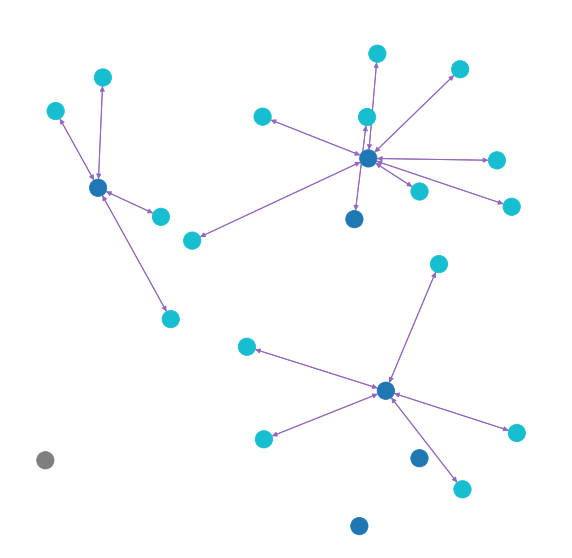

In [22]:
subsubg = subG.copy()
print(f"nodes {len(subsubg)}, edges: {len(subsubg.edges)}")
subsubg.remove_nodes_from([n for n in subsubg if n[0] == "v"])
print(f"nodes {len(subsubg)}, edges: {len(subsubg.edges)}")

draw_graph(subsubg, prog=None, node_label=False, edge_label=False)

In [50]:
print(describe_graph(subG))
print(describe_graph(subsubg))

{'nodes': 118, 'edges': 222, 'components': 1, 'density': 0.016079965232507605, 'diameter': 6, 'degree': 1.88135593220339}
{'nodes': 24, 'edges': 34, 'components': 7, 'density': 0.06159420289855073, 'diameter': None, 'degree': 1.4166666666666667}


In [58]:
attention_window = pd.Timedelta("1 day")
moment_time = timeline[1]
pr_alpha = 0.85
beta_a = 0.5
beta_b = 0.5

node_name = "u2337"
topic = 4
polarity = 0

print(f"{attention_window}, {moment_time}")

1 days 00:00:00, 2020-09-04 03:59:59+00:00


In [64]:
def compute_moment_pagerank(G, node_name, topic, polarity, pr_alpha, beta_a, beta_b, moment_time, attention_window, verbose=False):
    moment_nodes = [n for n in nx.descendants(G, node_name)
                    if G.nodes[n]["topic"] == topic and G.nodes[n]["polar"] == polarity] + [node_name]

    moment_graph = G.subgraph(moment_nodes).copy()
    if verbose:
        print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)}")
    moment_graph.nodes[node_name]["time"] = moment_time

    # remove edges outside attention window
    remove_edges = [e for e in moment_graph.edges if moment_graph.edges[e]["time"] > moment_time]
    for n in moment_graph:
        if n[0] in ["p", "u"]:
            t = moment_graph.nodes[n]["time"]
            remove_edges += [e for e in moment_graph.out_edges(n) if not t - attention_window < moment_graph.edges[e]["time"] <= t]

    if verbose:
        print(f"remove edges {len(remove_edges)}")
    moment_graph.remove_edges_from(remove_edges)
    if verbose:
        print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)} <- attention window")

    # for source node node_name only
    moment_graph = moment_graph.subgraph([n for n in moment_graph if nx.has_path(moment_graph, node_name, n)]).copy()
    if verbose:
        print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)} <- path from observer")

    # remove isolated nodes
    isolates = list(nx.isolates(moment_graph))
    if node_name in isolates:
        isolates.remove(node_name)
    moment_graph.remove_nodes_from(isolates)
    
    if verbose:
        print(f"nodes {len(moment_graph)}, edges: {len(moment_graph.edges)} <- remove isolates")

    beta_rv = beta(a=0.5, b=0.5)
    
    for node in moment_graph:
        elist = sorted(moment_graph.out_edges(node), key=lambda e: G.edges[e]["time"])
        x = np.linspace(0, 1, len(elist)+2)[1:-1]
        y = beta_rv.pdf(x)
        y = y / y.sum()
        for e, w in zip(elist, y):
            moment_graph.edges[e]["weight"] = w

    pr_value = nx.pagerank_numpy(moment_graph, alpha=pr_alpha, weight="weight")
    
    return moment_graph, pr_value

In [66]:
moment_graph, pr_value = compute_moment_pagerank(G, node_name, topic, polarity, pr_alpha, beta_a, beta_b, moment_time, attention_window, verbose=True)

nodes 3492, edges: 5097
remove edges 3534
nodes 3492, edges: 1870 <- attention window
nodes 45, edges: 82 <- path from observer
nodes 45, edges: 82 <- remove isolates


/home/rui/venvs/gcn/lib/python3.8/site-packages/pygraphviz/agraph.py:1390: RuntimeWarning: Warning: obsr is not a known color.

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


{'nodes': 45, 'edges': 82, 'components': 1, 'density': 0.04141414141414142, 'diameter': 4, 'degree': 1.8222222222222222}


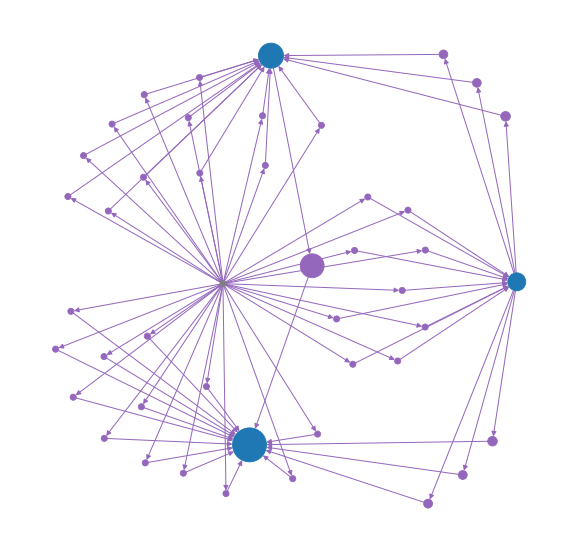

In [55]:
draw_graph(moment_graph, prog="neato", node_label=False, edge_label=False, pr_value=pr_value)

In [62]:
obsr_list = [f"u{u}" for u in df_users[df_users["isObserver"] == "t"]["id"]]

In [63]:
from tqdm.notebook import tqdm
# from multiprocessing import Pool
from joblib import Parallel, delayed
from pathlib import Path

In [75]:
def do_params(pr_alpha, beta_a, beta_b):
    keyq = [(node_name, t, topic, polar)
            for node_name in obsr_list for t in timeline[1:] for topic in range(8) for polar in [0, 2]
           ]
    print(f"jobs: {len(keyq)}")
    
    def short_compute_pagerank(n, t, topic, polar):
        g, pr = compute_moment_pagerank(
            G, n, topic, polar, pr_alpha, beta_a, beta_b, t, attention_window)
        return {"graph": describe_graph(g), "pr": pr}
    
    valueq = Parallel(n_jobs=30, backend="threading")(delayed(short_compute_pagerank)(*tup) for tup in tqdm(keyq))
    return dict(zip(keyq, valueq))

In [71]:
d = do_params(pr_alpha=0.9, beta_a=0.5, beta_b=0.5)

{'graph': {'nodes': 1,
  'edges': 0,
  'components': 1,
  'density': 0,
  'diameter': 0,
  'degree': 0.0},
 'pr': {'u2297': 1.0}}

### big number of values to compute
In total, there will be **21,250** jobs

+ Number of survey time for each user: 5
+ topics: 8
+ polarity: 2
+ Number of observers: 34
+ Number of parameters
    - Pagerank damping factor: 5
    - Beta alpha, beta: 5*5=25